# Dynamics Summary

This is a summary of the dynamics quantitites from a simulation presented in a way that is simple to check that the values are sensible before continuing with further analysis.

In [1]:
import pandas as pd
import altair as alt
# This is for the interactive elements
import ipywidgets as widgets

# We are dealing with datsets larger than the 5000 rows,
# so save the data to a json file and read from that.
alt.data_transformers.enable('csv');

The processing of the dataset has to be performed before this notebook will display anything useful. 
This processing can be performed using the command

```sh
make dynamics
```

in the root of this project directory.

In [2]:
# Reading the processed dataset which is generated by running `make dynamics`
df = pd.read_hdf('../data/analysis/dynamics_clean.h5', 'dynamics')

# Process the dataset which involves averaging over all the instances of start index
df = df.groupby(
    ['temperature', 'pressure', 'time']
).mean().reset_index()

Since this notebook is focused on an interactive summary of the data,
the next cell selects every 5th value from the dataset.
This behaviour can be changed by changing the `every_nth` variable,
note however, that reducing this value will increase the time for a figure to load.

In [3]:
df_plot = df.groupby(['temperature', 'pressure', 'time']).mean().reset_index()

This is the part where the generation of the figure takes place.
The selection of the pressure and the dyanmic quantity is designed to be interactive,
selecting the value of interest.

In [4]:
pressures = widgets.ToggleButtons(description="Pressure", options=df.pressure.unique())

# The metadata columns, or those we are using for the other axes of the figure
# shouldn't be available for plotting since they are non-sensical.
metadata_cols = ["temperature", "pressure", "start_index", "time"]
axes = widgets.ToggleButtons(
    description="Quantity", 
    options=[col for col in df.columns  if col not in metadata_cols]
)

@widgets.interact(pressure=pressures, axis=axes)
def create_chart(pressure, axis):
    c = alt.Chart(df_plot.query('pressure==@pressure'), width=600, height=500).mark_point(size=75).encode(
        alt.X('time', axis=alt.Axis(format='e'), scale=alt.Scale(type='log')),
        alt.Y(axis, type='quantitative'),
        alt.Color('temperature:N'),
        tooltip=['temperature', 'time', axis]
    )
    # Set log log scale for displacement figures
    if axis in ['msd', 'mfd', 'mean_displacement']:
        c.encoding.y.scale = alt.Scale(type='log')
        
    return c.interactive()

interactive(children=(ToggleButtons(description='Pressure', options=(1.0, 13.5), value=1.0), ToggleButtons(des…

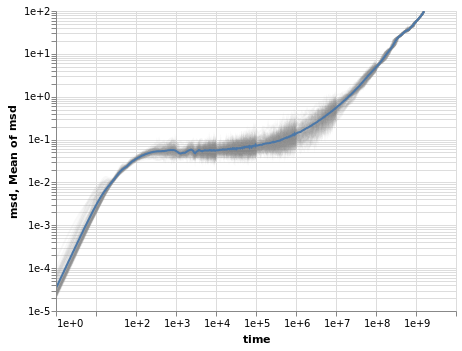

In [5]:
df = pd.read_hdf('../data/analysis/dynamics_clean.h5', 'dynamics')

pressure = 13.50
temperature = 1.30

df1 = df.query('temperature==@temperature and pressure==@pressure and start_index % 5 == 0')

c_base = alt.Chart(df1)

( 
    c_base.mark_line(color='grey', opacity=0.05).encode(
        x=alt.X('time', axis=alt.Axis(format='e'), scale=alt.Scale(type='log')),
        y=alt.Y('msd', axis=alt.Axis(format='e'), scale=alt.Scale(type='log')),
        detail='start_index',
    ) + 
    c_base.mark_line().encode(
        x='time',
        y='mean(msd)',
    )
).interactive()